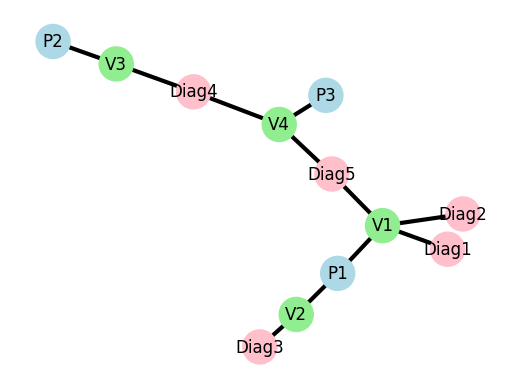

In [3]:
import dgl
import networkx as nx
import matplotlib.pyplot as plt

# Construct a heterogeneous graph using NetworkX
G = nx.Graph()

# # Add nodes for different entities in the EHR
# G.add_nodes_from(['Patient', 'Visit', 'Medication', 'Diagnosis', 'Diagnosis'])

# Add patient nodes
G.add_node("P1", node_type="patient")
G.add_node("P2", node_type="patient")
G.add_node("P3", node_type="patient")

# Add visit nodes
G.add_node("V1", node_type="visit")
G.add_node("V2", node_type="visit")
G.add_node("V3", node_type="visit")
G.add_node("V4", node_type="visit")

# Add diagnosis nodes
G.add_node("Diag1", node_type="diagnosis")
G.add_node("Diag2", node_type="diagnosis")
G.add_node("Diag3", node_type="diagnosis")
G.add_node("Diag4", node_type="diagnosis")
G.add_node("Diag5", node_type="diagnosis")

# Add edges between nodes
G.add_edge("P1", "V1")
G.add_edge("P1", "V2")
G.add_edge("P2", "V3")
G.add_edge("P3", "V4")
G.add_edge("V1", "Diag1")
G.add_edge("V1", "Diag2")
G.add_edge("V1", "Diag5")
G.add_edge("V2", "Diag3")
G.add_edge("V3", "Diag4")
G.add_edge("V4", "Diag5")
G.add_edge("V4", "Diag4")

# Add edges between the entities based on their relationships
# G.add_edges_from([('Patient', 'Visit'), ('Visit', 'Medication'), ('Visit', 'Diagnosis')])

# Set node attributes for better visualization
node_colors = {"patient": "lightblue", "visit": "lightgreen", "diagnosis": "pink"}
colors = [node_colors[G.nodes[n]["node_type"]] for n in G.nodes]
# node_size = {'Patient': 500, 'Doctor': 500, 'Medication': 500, 'Diagnosis': 500}
# nx.set_node_attributes(G, node_color, 'color')
# nx.set_node_attributes(G, node_size, 'size')
# nx.set_edge_attributes(G, 10, 'width')
# Draw the graph using matplotlib
pos = nx.spring_layout(G)
nx.draw_networkx_nodes(G, pos, node_color=colors, node_size=600)
nx.draw_networkx_labels(G, pos)
nx.draw_networkx_edges(G, pos, width=3)

# Show the graph
plt.axis('off')
plt.show()

## Visualization of Baseline Embeddings

In [4]:
import torch
import pickle
import yaml
from utils import ordered_yaml
import plotly.graph_objects as go

from pyhealth.tasks import (
    drug_recommendation_mimic3_fn,
    readmission_prediction_mimic3_fn,
    mortality_prediction_mimic3_fn,
    length_of_stay_prediction_mimic3_fn
)

from pyhealth.datasets import split_by_patient, get_dataloader, split_by_visit

In [5]:
with open("./configs/GAT_MIMIC3.yml", mode='r') as f:
    loader, _ = ordered_yaml()
    config = yaml.load(f, loader)

In [6]:
with open(config["datasets"]["dataset_path"], 'rb') as inp:
    unp = pickle.Unpickler(inp)
    mimic3base = unp.load()


In [7]:
sample_dataset = mimic3base.set_task(task_fn=readmission_prediction_mimic3_fn)
train_ds, val_ds, test_ds = split_by_visit(sample_dataset, [0.9, 0.1, 0])
test_loader = get_dataloader(val_ds, batch_size=512, shuffle=False)
data_batch = next(iter(test_loader))
pickle.dump(sample_dataset, "checkpoints/GAT_MIMIC3_READM")
del mimic3base

Generating samples for readmission_prediction_mimic3_fn: 100%|██████████| 46520/46520 [00:00<00:00, 76633.45it/s]


In [8]:
deepr_model_path = "./checkpoints/Deepr/mimic3/readm/20230706-075123/best.ckpt"
state_dict = torch.load(deepr_model_path, map_location=torch.device('cpu'))
state_dict

FileNotFoundError: [Errno 2] No such file or directory: './checkpoints/Deepr/mimic3/readm/20230706-075123/best.ckpt'

In [ ]:
from pyhealth.models import AdaCare
from parse import parse_baselines

model = parse_baselines(sample_dataset, "Deepr", "binary", "label")
model.load_state_dict(state_dict)
data_batch["embed"] = True
results = model(**data_batch)

In [ ]:
results["embed"] = results["embed"][:, 128:]+ results["embed"][:, :128]

In [ ]:
patient_emb = results["embed"]

In [ ]:
layout = go.Layout(
    autosize=False,
    width=600,
    height=600)
fig = go.Figure(layout=layout)
from sklearn.manifold import Isomap, TSNE

fig.update_layout(
    template="plotly"
)

tsne = TSNE(n_components=2)
embeddings_2d = tsne.fit_transform(state_dict["embeddings.conditions.weight"][:250].detach().cpu().numpy())
fig.add_trace(go.Scatter(x=embeddings_2d[:, 0], y=embeddings_2d[:, 1], mode='markers', name="diagnosis"))

tsne = TSNE(n_components=2)
embeddings_2d = tsne.fit_transform(state_dict["embeddings.procedures.weight"][:250].detach().cpu().numpy())
fig.add_trace(go.Scatter(x=embeddings_2d[:, 0], y=embeddings_2d[:, 1], mode='markers', name="procedures"))

tsne = TSNE(n_components=2)
embeddings_2d = tsne.fit_transform(patient_emb[:250].detach().cpu().numpy())
fig.add_trace(go.Scatter(x=embeddings_2d[:, 0], y=embeddings_2d[:, 1], mode='markers', name="patients"))

fig.show()
fig.write_image("./manuscripts/Deepr.jpg")

In [ ]:
stagenet_model_path = "./checkpoints/StageNet/mimic3/readm/20230705-154330/best.ckpt"
state_dict = torch.load(stagenet_model_path, map_location=torch.device('cpu'))
state_dict

In [ ]:
from pyhealth.models import AdaCare
from parse import parse_baselines

model = parse_baselines(sample_dataset, "StageNet", "binary", "label")
model.load_state_dict(state_dict)
data_batch["embed"] = True
results = model(**data_batch)
# results["embed"] = results["embed"][:, 128:]+ results["embed"][:, :128]
patient_emb = results["embed"][:, :128]

In [ ]:
layout = go.Layout(
    autosize=False,
    width=600,
    height=600)
fig = go.Figure(layout=layout)
from sklearn.manifold import Isomap, TSNE

fig.update_layout(
    template="plotly"
)

tsne = TSNE(n_components=2)
embeddings_2d = tsne.fit_transform(state_dict["embeddings.conditions.weight"][:250].detach().cpu().numpy())
fig.add_trace(go.Scatter(x=embeddings_2d[:, 0], y=embeddings_2d[:, 1], mode='markers', name="diagnosis"))

tsne = TSNE(n_components=2)
embeddings_2d = tsne.fit_transform(state_dict["embeddings.procedures.weight"][:250].detach().cpu().numpy())
fig.add_trace(go.Scatter(x=embeddings_2d[:, 0], y=embeddings_2d[:, 1], mode='markers', name="procedures"))

tsne = TSNE(n_components=2)
embeddings_2d = tsne.fit_transform(patient_emb[:250].detach().cpu().numpy())
fig.add_trace(go.Scatter(x=embeddings_2d[:, 0], y=embeddings_2d[:, 1], mode='markers', name="patients"))

fig.show()
fig.write_image("./manuscripts/Deepr.jpg")

# Visualize Attention Score

Attention score visualization for interpretability.

In [ ]:
import torch
import pickle
import yaml
from utils import ordered_yaml
import plotly.graph_objects as go

from pyhealth.tasks import (
    drug_recommendation_mimic3_fn,
    readmission_prediction_mimic3_fn,
    mortality_prediction_mimic3_fn,
    length_of_stay_prediction_mimic3_fn
)

from pyhealth.datasets import split_by_patient, get_dataloader, split_by_visit

In [ ]:
with open("./configs/GAT_MIMIC3.yml", mode='r') as f:
    loader, _ = ordered_yaml()
    config = yaml.load(f, loader)


In [ ]:
# Load mimic dataset
with open(config["datasets"]["dataset_path"], 'rb') as inp:
    unp = pickle.Unpickler(inp)
    mimic3base = unp.load()


In [ ]:
sample_dataset = mimic3base.set_task(task_fn=readmission_prediction_mimic3_fn)
del mimic3base

In [53]:
# Load graph
import pickle
import dgl
with open("checkpoints/GAT_MIMIC3_READM/graph_readm.pkl", 'rb') as inp:
    unp = pickle.Unpickler(inp)
    # state_dict = torch.load(deepr_model_path, map_location=torch.device('cpu'))
    g = unp.load()
g


Graph(num_nodes={'concepts': 50, 'diagnosis': 6984, 'patient': 46520, 'prescription': 4204, 'procedure': 2032, 'visit': 58976},
      num_edges={('concepts', 'newrelation', 'concepts'): 194, ('concepts', 'rev_newrelation', 'diagnosis'): 50, ('concepts', 'rev_newrelation', 'patient'): 50, ('concepts', 'rev_newrelation', 'prescription'): 50, ('concepts', 'rev_newrelation', 'procedure'): 50, ('concepts', 'rev_newrelation', 'visit'): 50, ('diagnosis', 'newrelation', 'concepts'): 50, ('diagnosis', 'rev_diagnosed', 'visit'): 651000, ('patient', 'makes', 'visit'): 58976, ('patient', 'newrelation', 'concepts'): 50, ('prescription', 'newrelation', 'concepts'): 50, ('prescription', 'rev_prescribed', 'visit'): 4151987, ('procedure', 'newrelation', 'concepts'): 50, ('procedure', 'rev_treated', 'visit'): 240095, ('visit', 'diagnosed', 'diagnosis'): 651000, ('visit', 'newrelation', 'concepts'): 50, ('visit', 'prescribed', 'prescription'): 4151987, ('visit', 'rev_makes', 'patient'): 58976, ('visit', 

In [54]:
homo_g = dgl.to_homogeneous(g)

In [55]:
with open('./checkpoints/GAT_MIMIC3_READM/readm_sample_dataset.pkl', 'wb') as outp:
    pickle.dump(sample_dataset, outp, pickle.HIGHEST_PROTOCOL)

NameError: name 'sample_dataset' is not defined

In [56]:
with open("./data/graphs/mimic3_dp_entity_mapping.pkl", 'rb') as inp:
    unp = pickle.Unpickler(inp)
    # state_dict = torch.load(deepr_model_path, map_location=torch.device('cpu'))
    entity_mapping = unp.load()


In [57]:
with open("checkpoints/GAT_MIMIC3_READM/attention_score_readm.pkl", 'rb') as inp:
    unp = pickle.Unpickler(inp)
    # state_dict = torch.load(deepr_model_path, map_location=torch.device('cpu'))
    attn_score = unp.load().sum(1).squeeze()

In [58]:
with open("checkpoints/GAT_MIMIC3_READM/entity_mapping.pkl", 'rb') as inp:
    unp = pickle.Unpickler(inp)
    # state_dict = torch.load(deepr_model_path, map_location=torch.device('cpu'))
    entity_mapping = unp.load()

In [59]:
selected_etype_id = 5

offset = 0
for t in range(selected_etype_id):
    temp = homo_g.edata["_ID"][homo_g.edata["_TYPE"] == t]
    offset += len(temp)

selected_eid = temp + offset

In [60]:
# temp = g.edata['a'].sum(1).squeeze()
import torch
top_scores, top_ind = torch.topk(attn_score[selected_eid], 10)

In [61]:
entity_mapping.keys()

dict_keys(['patient', 'visit', 'diagnosis', 'procedure', 'prescription', 'concept'])

In [62]:
top_ind

tensor([24, 40, 25, 29, 33, 22, 36, 18, 11, 32])

In [63]:
top_scores

tensor([2.3722, 1.8626, 1.8581, 1.4850, 1.4055, 1.4028, 1.3670, 1.3250, 1.2928,
        1.2590])

In [64]:
h, t, eid  = g.edges("all", etype=('visit', 'newrelation', 'concepts'))

In [65]:
h[torch.isin(eid, top_ind)]

tensor([11928,  5946, 25297,  2278, 57287, 23123,   393, 20831, 49121,   580])

In [66]:
t[torch.isin(eid, top_ind)]

tensor([11, 18, 22, 24, 25, 29, 32, 33, 36, 40])

In [67]:
rev_entity_mapping = {v:k for k, v in entity_mapping["concept"].items()}
top_concepts_and_scores = {}
for i, c in enumerate(t[torch.isin(eid, top_ind)]):
    top_concepts_and_scores.update({rev_entity_mapping[c.item()]: top_scores[i]})

top_concepts_and_scores

{'Anticoagulants': tensor(2.3722),
 'Antihypertensives': tensor(1.8626),
 'Arterial Blood Gases (ABG)': tensor(1.8581),
 'Electrocardiogram (ECG)': tensor(1.4850),
 'Chest X-Ray': tensor(1.4055),
 'Microbiological Cultures': tensor(1.4028),
 'Medical History': tensor(1.3670),
 'Surgical History': tensor(1.3250),
 'Acute Respiratory Distress Syndrome (ARDS)': tensor(1.2928),
 'Chronic Kidney Disease': tensor(1.2590)}

In [68]:
diag_dict = {v: k for k, v in entity_mapping["diagnosis"].items()}

In [69]:
entity_mapping

{'patient': {'10': 0,
  '100': 1,
  '1000': 2,
  '10000': 3,
  '10001': 4,
  '10002': 5,
  '10003': 6,
  '10004': 7,
  '10005': 8,
  '10006': 9,
  '10007': 10,
  '10008': 11,
  '10009': 12,
  '1001': 13,
  '10010': 14,
  '10011': 15,
  '10012': 16,
  '10013': 17,
  '10014': 18,
  '10015': 19,
  '10016': 20,
  '10017': 21,
  '10019': 22,
  '1002': 23,
  '10020': 24,
  '10021': 25,
  '10022': 26,
  '10023': 27,
  '10024': 28,
  '10025': 29,
  '10026': 30,
  '10027': 31,
  '10028': 32,
  '10029': 33,
  '1003': 34,
  '10030': 35,
  '10032': 36,
  '10033': 37,
  '10034': 38,
  '10035': 39,
  '10036': 40,
  '10037': 41,
  '10038': 42,
  '10039': 43,
  '1004': 44,
  '10040': 45,
  '10041': 46,
  '10042': 47,
  '10043': 48,
  '10044': 49,
  '10045': 50,
  '10046': 51,
  '10047': 52,
  '10048': 53,
  '10049': 54,
  '1005': 55,
  '10050': 56,
  '10051': 57,
  '10052': 58,
  '10054': 59,
  '10055': 60,
  '10056': 61,
  '10057': 62,
  '10058': 63,
  '10059': 64,
  '1006': 65,
  '10060': 66,
  '100

In [50]:
diag_dict[3521]

'75481'

5899 - 1983 - Secondary malignant neoplasm of brain and spinal cord
1397 - 3485 - Cerebral edema
6358 - V1005 - Personal history of malignant neoplasm of large intestine
3521 - V5865 - Long-term (current) use of steroids

In [ ]:
plt.figure(figsize=(20,6))
fig, ax = plt.subplots(1, 2)

data = norm.rvs(size=100,loc=0,scale=1)

x = np.linspace(-1, 3, 1000)
ax[0].plot(x, f.pdf(x, 10, 10),
       'r-', lw=5, alpha=0.6, label='F(10, 10)')
ax[0].plot(x, norm.pdf(x, 0, 1),
       'g-', lw=5, alpha=0.6, label='N(0,1)')
ax[0].legend(loc="upper right", fontsize="small")
ax[1].plot(x, f.pdf(x, 1000, 1000),
       'r-', lw=5, alpha=0.6, label='F(1000, 1000)')
ax[1].plot(x, norm.pdf(x, 0, 1),
       'g-', lw=5, alpha=0.6, label='N(0,1)')
ax[1].legend(loc="upper right", fontsize="x-small")
plt.savefig("./visualizations/norm_vs_F.jpg", dpi=600)

In [ ]:
from matplotlib import pyplot as plt
from scipy.stats import norm, f
import numpy as np